In [1]:
#!pip install statannotations

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
from statannotations.Annotator import Annotator #https://github.com/trevismd/statannotations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# if getting OptionError: "No such keys(s): 'mode.use_inf_as_null'"
# !pip install --upgrade seaborn pandas

import matplotlib as mpl
import os
from glob import glob

from _load_data import * # Getting our specific labels, formatting, and data

# Getting some free samples
results_df.sample(3)

print(gens)

# Don't change any code below, it may break (probably will) --------------------

['../models/SimplifierTopDownOnlyLast.py', '../models/Vanilla.py', '../models/SimplifierBottomUp1e-2.py', '../models/SimplifierBottomUp1e-4.py', '../models/SimplifierBottomUp1e-6.py', '../models/SimplifierTopDown1e-2.py', '../models/SimplifierBottomUp1e-1.py', '../models/SimplifierBottomUp1e-0.py', '../models/SimplifierTopDown1e-1.py', '../models/SimplifierBottomUp.py', '../models/SimplifierTopDown1e-10.py', '../models/SimplifierBottomUpOnlyLast.py', '../models/SimplifierTopDown1e-6.py', '../models/SimplifierTopDown1e-4.py', '../models/SimplifierBottomUp1e-10.py', '../models/SimplifierTopDown.py', '../models/SimplifierTopDown1e-0.py'] ['Top Down (only last)', 'Without simplify', 'Bottom Up 1e-2', 'Bottom Up 1e-4', 'Bottom Up 1e-6', 'Top Down 1e-2', 'Bottom Up 1e-1', 'Bottom Up 1e-0', 'Top Down 1e-1', 'Bottom Up', 'Top Down 1e-10', 'Bottom Up (only last)', 'Top Down 1e-6', 'Top Down 1e-4', 'Bottom Up 1e-10', 'Top Down', 'Top Down 1e-0']
(180, 14)
['Without simplify' 'Bottom Up' 'Top Dow

In [2]:
from sympy import *
import re

func_dict = {
    'multiply': '*',
    'subtract': '-',
    'add3': '+',
    'add4': '+',
    'mul3': '*',
    'mul4': '*',
    'cdiv': '/',
    'add': '+'
}

func_arity = {
    'multiply': 2,
    'subtract': 2,
    'add3': 3,
    'add4': 4,
    'mul3': 3,
    'mul4': 4,
    'cdiv': 2,
    'add': 2,
    'maximum' : 2,
    'minimum' : 2,
    'max' : 2,
    'min' : 2,
    'sin' : 1,
    'cos' : 1,
    'tan' : 1,
    'arcsin' : 1,
    'arccos' : 1,
    'arctan' : 1,
    'sqrtabs' : 1,
    'sqrt' : 1,
    'abs' : 1,
    'log1p'   : 1,
    'log'     : 1,
    'exp'     : 1,
    'expm1'   : 1,
    'square'  : 1,
    'absolute' : 1
}

def pretify_expr(string):
    # Breaking down into a list of symbols. handliilng sqrtabs and max/minimum
    ind = string.replace('sqrtabs','sqrt').replace('imum','') \
                .replace(' ','').replace(')','').replace('(',',').split(',')

    new_string = ""
    stack = []
    for node in ind:
        stack.append((node, []))
        while len(stack[-1][1]) == func_arity.get(stack[-1][0], 0):

            prim, args = stack.pop()
            new_string = prim
            if prim in func_dict.keys():
                new_string = '(' + func_dict[prim].join(args) + ')'
            elif not prim.startswith('x_'):
                try:
                    float(prim)
                except:
                    new_string = prim + '(' + args[0] + ')'
                
            if len(stack) == 0:
                break

            stack[-1][1].append(new_string)

    return new_string

def count_float_occurrences(s):
   pattern = r'\d+\.\d+' # Matches sequences of digits followed by a dot and more digits
   matches = re.findall(pattern, s)
   return len(matches)

def count_occurrences(s, sub):
   res = 0
   for i in range(len(s)):
       if s[i:i+len(sub)] == sub:
           res += 1
   return res

funcs = [
    '-', '+', '+', '/', 'maximum', 'minimum', 'max', 'min', 'sin', 'cos', 'tan', 
    'arcsin', 'arccos', 'arctan', 'sqrtabs', 'expm1',
    'sqrt', 'abs', 'log1p', 'log', 'exp', 'square', 'absolute']

In [3]:
new_columns = []

for i, col in results_df.iterrows():
    sympy_compatible = str(pretify_expr(col['representation']))
    try:
        sympy_simplified = str(simplify(sympy_compatible))
    except Exception as e:
        print(e)
        continue
    # stats: number of functions, constants, variables, and total number ofnodes
    n_features_before  = count_occurrences(sympy_compatible, "x_")
    n_constants_before = count_float_occurrences(sympy_compatible)
    n_functions_before = sum([count_occurrences(sympy_compatible, f)
                              for f in funcs])

    n_features_after  = count_occurrences(sympy_simplified, "x_")
    n_constants_after = count_float_occurrences(sympy_simplified)
    n_functions_after = sum([count_occurrences(sympy_simplified, f)
                             for f in funcs])

    new_columns.append([
        n_features_before-n_features_after,
        n_constants_before-n_constants_after,
        n_functions_before-n_functions_after,
        (n_features_before+n_constants_before+n_functions_before)-\
        (n_features_after+n_constants_after+n_functions_after),
    ])

deltas_df = pd.DataFrame(new_columns, columns=['features simplified',
                                               'constants simplified',
                                               'functions simplified',
                                               'nodes simplified'])

results_df = pd.concat([results_df, deltas_df], axis=1 )
results_df.sample(3)

,model,dataset,RunID,random_state,time,date,train_r2,test_r2,train_mse,test_mse,representation,size,complexity,depth,features simplified,constants simplified,functions simplified,nodes simplified
71,Bottom Up,Energy Cooling,0.0,6933.0,187.234231,01-25-2024 21:31:01,0.882735,0.891994,9.840672,8.680194,"minimum(40.01555555555556, multiply(add4(cdiv(-2778.1636026708234, add(log(x_0), add(x_0, x_4))), mul3(log1p(x_4), add4(-140.83491445509813, x_5, x_2, cos(x_5)), add(x_0, x_6)), add3(377.8549402273164, x_5, x_3), add(x_3, x_5)), 0.04622321476314434))",32.0,8076.0,6.0,0.0,-2.0,0.0,-2.0
25,Top Down,Airfoil,0.0,1318.0,798.719360,01-25-2024 21:37:43,0.343887,0.480869,18.349322,14.959772,"add(129.80376916830284, cdiv(mul3(log1p(cdiv(mul3(x_4, x_0, x_2), log(x_4))), -142332438796.0451, subtract(5.661171543994431, log(subtract(x_3, x_4)))), add4(subtract(x_4, x_0), add(mul3(log(x_4), add3(-187633533251.57828, x_4, x_4), add(x_4, x_4)), -3869907873038.9556), add3(x_1, subtract(x_4, x_0), mul3(add3(-50747172426.699005, x_0, x_3), x_4, add(x_1, x_4))), 3875702832655.4883)))",50.0,13372.0,6.0,-7.0,-6.0,-5.0,-18.0
41,Bottom Up,Concrete,0.0,6933.0,359.060376,01-25-2024 21:30:23,0.804787,0.791006,50.141157,46.822179,"minimum(multiply(sqrtabs(mul3(add(-21.745047568095682, cdiv(12540.03025711362, x_3)), add(add4(x_0, x_1, x_1, -578664.7747277969), add(x_2, 578528.0632456737)), x_0)), log1p(cdiv(log1p(x_7), x_3))), cdiv(27071.644104027564, cdiv(-66194.15922045943, x_3)))",29.0,6261.0,6.0,0.0,1.0,8.0,9.0


[[<Axes: ylabel='features simplified'>]]


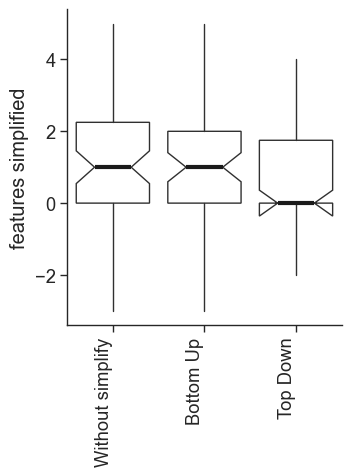

[[<Axes: ylabel='constants simplified'>]]


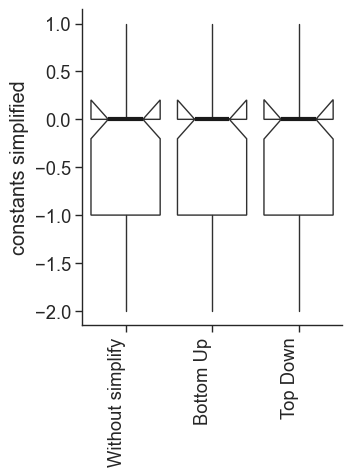

[[<Axes: ylabel='functions simplified'>]]


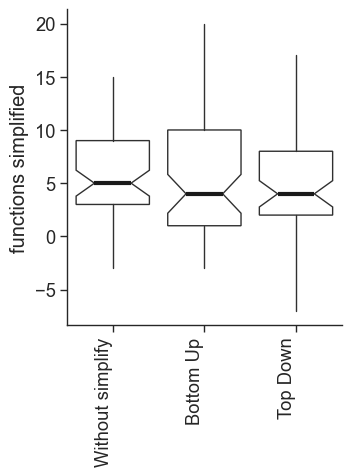

[[<Axes: ylabel='nodes simplified'>]]


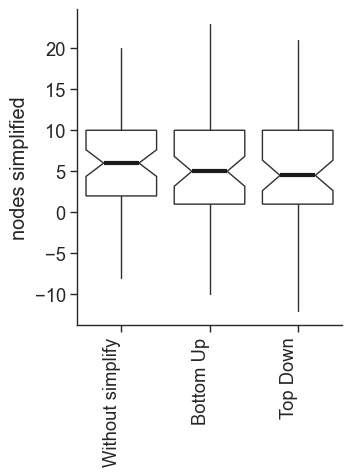

In [4]:
for yaxis in deltas_df.columns:
    g=sns.catplot( data=results_df, y=yaxis, x='model', 
        legend_out=False, aspect=0.75,
        order = order, # The first is Baseline
        **{**boxplot_kwargs, **{'showfliers':False}}, sharey=False
    )

    # g.set(yscale="log")
    g.set_titles("{col_name}").set_axis_labels("", yaxis)

    print(g.axes)

    # iterate through each subplot / Facet>

    for tick in g.axes[0][0].get_xticklabels():
        tick.set(rotation=90, ha="right")

    if False:
        # All vs baseline
        pairs = [('Without simplify', l)
                    for l in results_df['model'].unique()
                    if l != 'Without simplify']

        annotator = Annotator(
            plot_ax, pairs, data=results_df,
            x='model', y=yaxis,
            order=order)
        annotator.reset_configuration()
        annotator.configure(test="Mann-Whitney", hide_non_significant=True, #text_format='full',
                                comparisons_correction="holm", verbose=1, text_offset=-3)
        annotator.apply_and_annotate()

    plt.tight_layout()
    plt.savefig(f"../paper/figs/{yaxis}_boxplot.pdf")
    plt.savefig(f"../paper/figs/{yaxis}_boxplot.png")
    plt.show()